# Prepare dataset for training #

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.model_selection import train_test_split

In [2]:
class ImageDataset(Dataset):
    def __init__(self, path: str, parameters: pd.DataFrame, transform=None) -> None:
        self.image_paths = np.array([path + filename for filename in parameters['filename'].to_numpy()])
        self.labels = parameters['epsilon'].to_numpy()
        self.transform = transform

    def __getitem__(self, inx):
        image_path = self.image_paths[inx]
        label_float_epsilon = self.labels[inx]
        target = np.zeros(shape=(1000,))
        target[int(label_float_epsilon*1000)] = 1
        image = Image.open(image_path)
        image = np.array(image)
        # repeat grayscale value three times for all RGB channels
        image = np.repeat(image[..., np.newaxis], 3, -1)
        if self.transform:
            image = self.transform(image)
        return image, torch.from_numpy(target)

    def __len__(self):
        return len(self.image_paths)

In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
# read csv with steel images
all_steel_df = pd.read_csv("../data/generated/fourier/steel/freq/freq_parameters.csv", index_col=False)
avg_steel_df = pd.read_csv("../data/generated/fourier/steel/freq/freq_single_parameters.csv", index_col=False)

In [5]:
all_steel_df.head()

,width,height,epsilon,ring_center_width,ring_center_height,min_brightness,max_brightness,used_noise,filename
0,640,480,0.0,314,238,89,192,-1,fourier_steel_freq_00000.png
1,640,480,0.0,315,238,80,208,-1,fourier_steel_freq_00001.png
2,640,480,0.0,319,238,89,203,-1,fourier_steel_freq_00002.png
3,640,480,0.0,326,240,92,206,-1,fourier_steel_freq_00003.png
4,640,480,0.0,321,238,91,194,-1,fourier_steel_freq_00004.png


In [6]:
# add prefix "all/steel/" to the filename column
all_steel_df['filename'] = "fourier/steel/freq/" + all_steel_df['filename'].astype(str)
# the same for the average dataframe
avg_steel_df['filename'] = "fourier/steel/freq/" + avg_steel_df['filename'].astype(str)

In [7]:
main_dir = "../data/generated/"

In [8]:
all_steel_train, all_steel_test = train_test_split(all_steel_df, test_size=0.4, random_state=12, shuffle=True, stratify=all_steel_df['epsilon'])
all_steel_test, all_steel_valid = train_test_split(all_steel_test, test_size=1000, random_state=12, shuffle=True, stratify=all_steel_test['epsilon'])

In [9]:
avg_steel_train, avg_steel_test = train_test_split(avg_steel_df, test_size=0.4, random_state=12, shuffle=True, stratify=avg_steel_df['epsilon'])
avg_steel_test, avg_steel_valid = train_test_split(avg_steel_test, test_size=1000, random_state=12, shuffle=True, stratify=avg_steel_test['epsilon'])



In [10]:
main_params_dir = "../data/generated/"
blackbox_csv = pd.read_csv(main_params_dir+"blackbox_train.csv", index_col=False)
blackbox_csv["filename"] = "blackbox/" + blackbox_csv["filename"].astype(str)
blackbox_train, blackbox_valid = train_test_split(blackbox_csv, test_size=1000, random_state=12, shuffle=True, stratify=blackbox_csv['epsilon'])

bubble_csv = pd.read_csv(main_params_dir+"bubble_train.csv", index_col=False)
bubble_csv["filename"] = "bubble/" + bubble_csv["filename"].astype(str)
bubble_train, bubble_valid = train_test_split(bubble_csv, test_size=1000, random_state=12, shuffle=True, stratify=bubble_csv['epsilon'])

pizza_csv = pd.read_csv(main_params_dir+"pizza_train.csv", index_col=False)
pizza_csv["filename"] = "pizza/" + pizza_csv["filename"].astype(str)
pizza_train, pizza_valid = train_test_split(pizza_csv, test_size=1000, random_state=12, shuffle=True, stratify=pizza_csv['epsilon'])

pure_csv = pd.read_csv(main_params_dir+"pure_train.csv", index_col=False)
pure_csv["filename"] = "pure/" + pure_csv["filename"].astype(str)
pure_train, pure_valid = train_test_split(pure_csv, test_size=1000, random_state=12, shuffle=True, stratify=pure_csv['epsilon'])


# laod test csv
blackbox_test = pd.read_csv(main_params_dir+"blackbox_test.csv", index_col=False)
blackbox_test["filename"] = "blackbox/" + blackbox_test["filename"].astype(str)

bubble_test = pd.read_csv(main_params_dir+"bubble_test.csv", index_col=False)
bubble_test["filename"] = "bubble/" + bubble_test["filename"].astype(str)

pizza_test = pd.read_csv(main_params_dir+"pizza_test.csv", index_col=False)
pizza_test["filename"] = "pizza/" + pizza_test["filename"].astype(str)

pure_test = pd.read_csv(main_params_dir+"pure_test.csv", index_col=False)
pure_test["filename"] = "pure/" + pure_test["filename"].astype(str)

In [11]:
DATASETS = {
    "all": {
        "train": all_steel_train,
        "valid": all_steel_valid,
        "test": all_steel_test
    },
    "average": {
        "train": avg_steel_train,
        "valid": avg_steel_valid,
        "test": avg_steel_test
    },
    "blackbox": {
        "train": blackbox_train,
        "valid": blackbox_valid,
        "test": blackbox_test
    },
    "bubble": {
        "train": bubble_train,
        "valid": bubble_valid,
        "test": bubble_test
    },
    "pizza": {
        "train": pizza_train,
        "valid": pizza_valid,
        "test": pizza_test
    },
    "pure": {
        "train": pure_train,
        "valid": pure_valid,
        "test": pure_test
    },
}

In [12]:
# combine all datasets
best_train = pd.concat([DATASETS["pure"]["train"], 
                        DATASETS["average"]["train"],
                        DATASETS["all"]["train"],
                        DATASETS["blackbox"]["train"],
                        DATASETS["bubble"]["train"],
                        DATASETS["pizza"]["train"]]).sample(frac=1, random_state=12).reset_index(drop=True)

best_valid = pd.concat([DATASETS["pure"]["valid"], 
                        DATASETS["average"]["valid"],
                        DATASETS["all"]["valid"],
                        DATASETS["blackbox"]["valid"],
                        DATASETS["bubble"]["valid"],
                        DATASETS["pizza"]["valid"]]).sample(frac=1, random_state=12).reset_index(drop=True)

In [13]:
train_dataset = ImageDataset(path=main_dir,
                             parameters=best_train,
                             transform=transform)
valid_dataset = ImageDataset(path=main_dir,
                             parameters=best_valid,
                             transform=transform)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=0)

In [15]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

In [16]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
lr = 1e-4
epochs = 15
print(device)

cuda


In [17]:
def cyclic_MAE(outputs, targets):
    x1 = torch.minimum(torch.abs(outputs-targets), torch.minimum(torch.abs(outputs-targets+1), torch.abs(outputs-targets-1)))
    return torch.mean(x1)

In [18]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [19]:
model = models.resnet18(pretrained=True)

classifier = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, 1000)
)

model.fc = classifier

c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=lr, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.9, min_lr=1e-5)

In [21]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()

for epoch in range(epochs):
    model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader):
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    model.eval()
    fin_targets=[]
    fin_outputs=[]
    valid_batch_losses=[]
    with torch.no_grad():
        for data, labels in valid_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history['valid_losses'].append(valid_loss)
    
    if min_valid_loss > valid_loss:
        torch.save(model.state_dict(), '../models/best_steel_fourier_freq_model.pth')
        min_valid_loss = valid_loss
    
    print(f'Epoch {epoch} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    scheduler.step(valid_loss)


    torch.save(model.state_dict(), '../models/final_steel_fourier_freq_model.pth')

100%|██████████| 1125/1125 [06:53<00:00,  2.72it/s]


Epoch 0 		 Training Loss: 0.023167431092581132 		 Validation Loss: 0.008006697042446848


100%|██████████| 1125/1125 [06:25<00:00,  2.92it/s]


Epoch 1 		 Training Loss: 0.008033879315470498 		 Validation Loss: 0.006749283626182382


100%|██████████| 1125/1125 [05:16<00:00,  3.55it/s]


Epoch 2 		 Training Loss: 0.006501430312893476 		 Validation Loss: 0.005579463192571554


100%|██████████| 1125/1125 [03:42<00:00,  5.05it/s]


Epoch 3 		 Training Loss: 0.00573903904141068 		 Validation Loss: 0.005077103901604148


100%|██████████| 1125/1125 [03:42<00:00,  5.06it/s]


Epoch 4 		 Training Loss: 0.005290605825891655 		 Validation Loss: 0.00480787614704957


100%|██████████| 1125/1125 [03:41<00:00,  5.07it/s]


Epoch 5 		 Training Loss: 0.004963280203887928 		 Validation Loss: 0.00451060448420916


100%|██████████| 1125/1125 [03:42<00:00,  5.05it/s]


Epoch 6 		 Training Loss: 0.004687786103171505 		 Validation Loss: 0.004306351048288762


100%|██████████| 1125/1125 [03:41<00:00,  5.08it/s]


Epoch 7 		 Training Loss: 0.004475224341213918 		 Validation Loss: 0.004131540943820975


100%|██████████| 1125/1125 [03:41<00:00,  5.07it/s]


Epoch 8 		 Training Loss: 0.004287528324618292 		 Validation Loss: 0.003999130385294483


100%|██████████| 1125/1125 [03:40<00:00,  5.10it/s]


Epoch 9 		 Training Loss: 0.004119319306325924 		 Validation Loss: 0.0038634674313058597


100%|██████████| 1125/1125 [04:10<00:00,  4.49it/s]


Epoch 10 		 Training Loss: 0.003987688815744141 		 Validation Loss: 0.0037865191817942783


100%|██████████| 1125/1125 [06:39<00:00,  2.82it/s]


Epoch 11 		 Training Loss: 0.003876889797365379 		 Validation Loss: 0.003669977271815329


100%|██████████| 1125/1125 [06:43<00:00,  2.79it/s]


Epoch 12 		 Training Loss: 0.003776617423027646 		 Validation Loss: 0.003617928023103498


100%|██████████| 1125/1125 [06:44<00:00,  2.78it/s]


Epoch 13 		 Training Loss: 0.0036824209069079073 		 Validation Loss: 0.003588695381339454


100%|██████████| 1125/1125 [06:36<00:00,  2.84it/s]


Epoch 14 		 Training Loss: 0.0036054034266598343 		 Validation Loss: 0.0034679822665071467


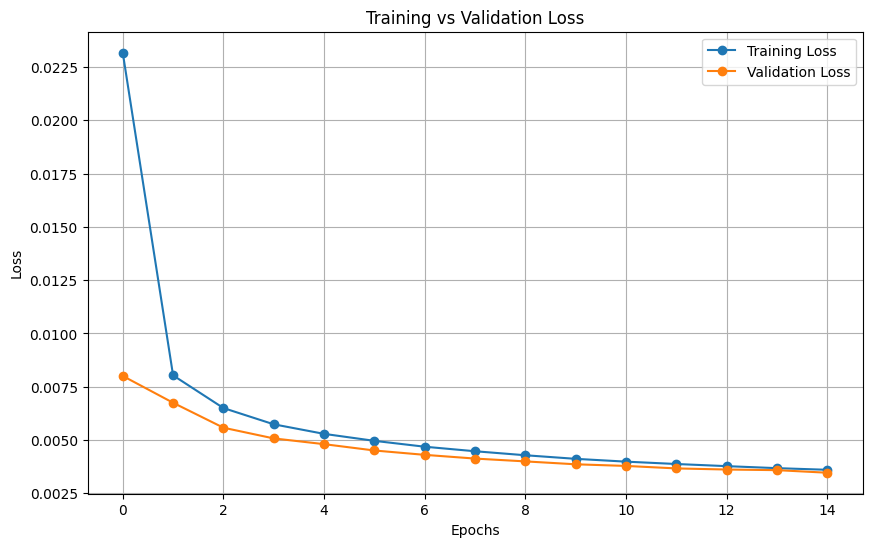

In [1]:
import matplotlib.pyplot as plt

# Data from the training log
epochs = list(range(15))
training_loss = [0.023167431092581132, 0.008033879315470498, 0.006501430312893476, 0.00573903904141068, 0.005290605825891655, 
                 0.004963280203887928, 0.004687786103171505, 0.004475224341213918, 0.004287528324618292, 0.004119319306325924, 
                 0.003987688815744141, 0.003876889797365379, 0.003776617423027646, 0.0036824209069079073, 0.0036054034266598343]
validation_loss = [0.008006697042446848, 0.006749283626182382, 0.005579463192571554, 0.005077103901604148, 0.00480787614704957, 
                   0.00451060448420916, 0.004306351048288762, 0.004131540943820975, 0.003999130385294483, 0.0038634674313058597, 
                   0.0037865191817942783, 0.003669977271815329, 0.003617928023103498, 0.003588695381339454, 0.0034679822665071467]

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# load the model from state_dict
model.load_state_dict(torch.load('../models/best_steel_fourier_freq_model.pth'))
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model testing ##

In [23]:
def test(test_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [24]:
def cyclic_MAE_test(output, target):
    return min(abs(output-target), min(abs(output-target+1), abs(output-target-1)))

In [25]:
def save_results(outputs, targets, filename: str):
    epsilons = []
    predicted = []
    differences = []
    for out, tar in zip(outputs, targets):

        epsilons.append(tar.index(1)/1000)
        predicted.append(out.index(1)/1000)
        differences.append(cyclic_MAE_test(out.index(1)/1000, tar.index(1)/1000))
    results_df = pd.DataFrame(list(zip(epsilons, predicted, differences)),
                  columns =['epsilon', 'predicted', 'loss'])
    results_df.to_csv(filename, index=False)
    return results_df

In [27]:
test_sets = ["all", "average", "blackbox", "bubble", "pizza", "pure"]

for test_set in test_sets:
    test_dataset = ImageDataset(path=main_dir,
                                parameters=DATASETS[test_set]["test"],
                                transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    outputs, targets = test(test_loader)
    outputs_numpy = np.array(outputs)
    out = np.zeros_like(outputs_numpy)
    out[np.arange(len(outputs_numpy)), outputs_numpy.argmax(1)] = 1
    out = out.tolist()
    results_df = save_results(out, targets, f"../data/results/steel_fourier/best_steel_fourier_freq_model-{test_set}_results.csv")
    print(f"{test_set} CyclicMAE: {results_df['loss'].mean()}")

100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


all CyclicMAE: 0.0023236666666666666


100%|██████████| 94/94 [00:35<00:00,  2.64it/s]


average CyclicMAE: 0.0018863333333333336


100%|██████████| 94/94 [00:17<00:00,  5.33it/s]


blackbox CyclicMAE: 0.0037563333333333346


100%|██████████| 94/94 [00:18<00:00,  5.20it/s]


bubble CyclicMAE: 0.0019753333333333333


100%|██████████| 94/94 [00:18<00:00,  5.17it/s]


pizza CyclicMAE: 0.0020343333333333333


100%|██████████| 94/94 [00:17<00:00,  5.26it/s]


pure CyclicMAE: 0.001823666666666667


In [23]:
# load test sets for ceramic
ceramic_average = pd.read_csv("../data/generated/average/ceramic/average_test.csv", index_col=False)
ceramic_all = pd.read_csv("../data/generated/all/ceramic/all_test.csv", index_col=False)

In [27]:
# add prefix "all/ceramic/" to the filename column
ceramic_all['filename'] = "all/ceramic/" + ceramic_all['filename'].astype(str)\
# the same for the average dataframe
ceramic_average['filename'] = "average/ceramic/" + ceramic_average['filename'].astype(str)

In [28]:
# ceramic test sets
ceramic_test_sets = ["average", "all"]
ceramic_mapping = {
    "average": ceramic_average,
    "all": ceramic_all
}

for test_set in ceramic_test_sets:
    test_dataset = ImageDataset(path=main_dir,
                                parameters=ceramic_mapping[test_set],
                                transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    outputs, targets = test(test_loader)
    outputs_numpy = np.array(outputs)
    out = np.zeros_like(outputs_numpy)
    out[np.arange(len(outputs_numpy)), outputs_numpy.argmax(1)] = 1
    out = out.tolist()
    results_df = save_results(out, targets, f"../data/results/steel/best_steel_model-{test_set}_ceramic_results.csv")
    print(f"{test_set} CyclicMAE: {results_df['loss'].mean()}")

100%|██████████| 94/94 [00:21<00:00,  4.48it/s]


average CyclicMAE: 0.015998333333333333


100%|██████████| 94/94 [00:33<00:00,  2.83it/s]


all CyclicMAE: 0.017707999999999998


# Test the Ceramic Model #

In [31]:
model.load_state_dict(torch.load('../models/final_model_best.pth'))
model.cuda()
model = model.eval()

In [32]:
test_sets = ["all", "average"]

for test_set in test_sets:
    test_dataset = ImageDataset(path=main_dir,
                                parameters=DATASETS[test_set]["test"],
                                transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    outputs, targets = test(test_loader)
    outputs_numpy = np.array(outputs)
    out = np.zeros_like(outputs_numpy)
    out[np.arange(len(outputs_numpy)), outputs_numpy.argmax(1)] = 1
    out = out.tolist()
    results_df = save_results(out, targets, f"../data/results/steel/best_ceramic_model-{test_set}_steel_results.csv")
    print(f"{test_set} CyclicMAE: {results_df['loss'].mean()}")

100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


all CyclicMAE: 0.007207000000000001


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


average CyclicMAE: 0.006045333333333334
